<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/ML_Modelfirst_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this notebook has the following models: svm, svm+ RBF kernel, and gradient boosting

In [11]:

import csv
import shutil
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2

**DOWNLOAD COUGHVID DATASET**

In [5]:
!wget https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
# https://zenodo.org/record/4048312/files/public_dataset.zip?download=1 (older version of ds)
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip


--2022-02-16 14:40:24--  https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332806163 (1.2G) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>]   1.24G  2.01MB/s    in 20m 57s 

2022-02-16 15:01:23 (1.01 MB/s) - ‘public_dataset.zip?download=1’ saved [1332806163/1332806163]



**COUGVID DATASET CONTAINS AUDIO FILES WITH .WEBM AND .OGG EXTENSION, THE OGG FILES WERE REMOVED AND THE WEBM FILES WERE CONVERTED TO WAV**

In [6]:
#remove .ogg files  
for file in os.listdir('public_dataset'):
    if file.endswith(".ogg") :
        os.remove('public_dataset/'+file)
        
        name, file_extension=os.path.splitext(file)
        os.remove('public_dataset/'+name+'.json')
  

In [7]:
c=0
j=0
for file in os.listdir('public_dataset'):
    if file.endswith(".webm") :
        c+=1
        
    if file.endswith(".json") :
       j+=1
print(c)
print(j)

25985
25985



**SELECT COVID SAMPLES FROM COUGHVID DATASET**


In [8]:
count=0
webm_count=0
covid_samples_count=0
reduced=0
bad=0

selected_filenames=[]
coughvid_webm_files=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        count+=1
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='COVID-19'):
                    covid_samples_count+=1

                    if 'expert_labels_1' in data:
                        if(data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_2' in data:
                        if(data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    elif 'expert_labels_3' in data:
                        if(data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good'):
                            reduced+=1
                            selected_filenames.append(path)
                    else:
                        reduced+=1
                        selected_filenames.append(path)
        if file.endswith(".webm"):
           webm_count+=1
           coughvid_webm_files.append(file)


In [9]:
print(selected_filenames)

['public_dataset/7c0c7e95-4a6b-4d75-b46c-6cb8cf280094.json', 'public_dataset/d57d4c31-4f34-41cd-9fdf-84e4df3f2dcc.json', 'public_dataset/8bb8315c-9afe-4205-911f-222c912f980e.json', 'public_dataset/ecc957af-3001-4a29-935a-32db98540746.json', 'public_dataset/c91409af-d36d-4ec3-a26d-ba640c97c90c.json', 'public_dataset/bac8326b-2652-443d-8b58-af96cdf5284d.json', 'public_dataset/2018bfea-0071-4aca-8d45-18dac4d65199.json', 'public_dataset/d4e4b900-939e-48e9-ad9f-bf9eee425303.json', 'public_dataset/36535622-407d-4226-adad-48b010e8ee83.json', 'public_dataset/a1f69db9-81f4-4a07-9808-dd1c99053125.json', 'public_dataset/ed4ba184-bc38-4372-84c0-62485a79ec1b.json', 'public_dataset/8ebca537-22d5-45fd-9f1c-60a58622284d.json', 'public_dataset/ee42cab8-6560-49b4-bb5e-bdeaa8f99751.json', 'public_dataset/adaff9bb-1718-48b0-b376-2403b4603fa7.json', 'public_dataset/b60e7ee3-64c2-4982-8212-750b4dbe8c66.json', 'public_dataset/a5025365-abca-4ff4-a335-a692389b7553.json', 'public_dataset/16f9b161-86c6-4af1-99cb

In [10]:
print("Total Number of samples :",count)
print("\nTotal Number of COVID-19 samples with cough_detected score>0.9 :",covid_samples_count)
print("\nExpert labeled COVID-19 samples with quality good/ok OR not expert labelled :",reduced)

Total Number of samples : 25985

Total Number of COVID-19 samples with cough_detected score>0.9 : 485

Expert labeled COVID-19 samples with quality good/ok OR not expert labelled : 424


SAVE +VE SAMPLES

In [12]:
!mkdir coughvidpos


In [13]:


for i in selected_filenames:
    name=os.path.splitext(i)[0]
    filepath=name+'.webm'
    shutil.copy(filepath,'/content/coughvidpos')



In [14]:

c=0
for f in os.listdir('/content/coughvidpos'):
    c+=1
print(c)


424


SELECT HEALTHY SAMPLES FROM COUGHVID DATASET


In [15]:
!mkdir coughvidnegative

In [16]:
healthy_samples=0
reduced=0
paths=[]

for file in os.listdir('public_dataset'):
    if file.endswith(".json"):
        
        path=os.path.join('public_dataset',file)
        
        f=open(path,"r")
        data=json.loads(f.read())
        
        if float(data['cough_detected'])>0.9:
            if 'status' in data:
                if(data['status']=='healthy'):
                    healthy_samples+=1

                    if 'expert_labels_1' in data:
                        if((data['expert_labels_1']['quality']=='ok' or data['expert_labels_1']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_2' in data:
                        if((data['expert_labels_2']['quality']=='ok' or data['expert_labels_2']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    elif 'expert_labels_3' in data:
                        if((data['expert_labels_3']['quality']=='ok' or data['expert_labels_3']['quality']=='good')):
                            reduced+=1
                            paths.append(path)
                    else:
                        reduced+=1
                        paths.append(path)
                        
    if reduced==1000:
        break

In [17]:
print("Number of healthy cough sound samples considered : ",reduced)

Number of healthy cough sound samples considered :  1000


In [18]:

cougvidnegatuve = '/content/coughvidnegative'
for i in paths:
    name=os.path.splitext(i)[0]
    filepath=name+'.webm'
    shutil.copy(filepath,cougvidnegatuve)

In [19]:

c=0
for f in os.listdir('/content/coughvidnegative'):
    c+=1
print(c)


1000


In [20]:
!mkdir val train test
!mkdir COVID HEALTHY
!mkdir val/COVID 
!mkdir val/HEALTHY
!mkdir test/COVID 
!mkdir test/HEALTHY
!mkdir train/COVID 
!mkdir train/HEALTHY

In [21]:
import soundfile as sf
for filename in os.listdir('/content/coughvidpos'):
        samples, sr = librosa.load('/content/coughvidpos/'+filename, sr=None)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/COVID/'+audio_file+'.wav',samples,sr)
 

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [22]:
len([file for file in os.listdir('COVID')])

424

In [23]:

for filename in os.listdir('/content/coughvidnegative'):
        samples, sr = librosa.load('/content/coughvidnegative/'+filename, sr=None)
        audio_file=  filename.split("/")[-1][0:-5]
        sf.write ('/content/HEALTHY/'+audio_file+'.wav',samples,sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [24]:
len([file for file in os.listdir('HEALTHY')])

1000

**KAGGLE DATASET ( A SUBSET FROM COSWARA)**
a subset from coswara was used, this dataset has about 56 covid samples which were added to the covid samples from coughvid
ps: only shallow coughs were used here 

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/Kaggle"

In [27]:
!kaggle datasets download -d praveengovi/coronahack-respiratory-sound-dataset

100% 6.80G/6.82G [00:54<00:00, 171MB/s]
100% 6.82G/6.82G [00:54<00:00, 133MB/s]


In [28]:
!unzip coronahack-respiratory-sound-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/breathing-deep.wav  
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/breathing-shallow.wav  
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/cough-heavy.wav  
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/cough-shallow.wav  
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/counting-fast.wav  
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/counting-normal.wav  
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/metadata.json  
  inflating: CoronaHack-Respiratory-Sound-Dataset/data/train/20200419/PAngvEIaGxXq92VkTOyQPquFkVI2/vowel-a.wav  
  

In [29]:
with open('/content/CoronaHack-Respiratory-Sound-Dataset/Corona-Hack-Respiratory-Sound-Metadata.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
      print(row[3])
      print(row[27])
      print(row[30])
      print(row[31])
      break

COVID_STATUS
DATES
cough-heavy
cough-shallow


In [30]:
#Add covid cough sound samples from the 'CoronaHack-respiratory-sound-dataset' to COVID FOLDER


healthy_count=0
covid_pos_count=0
with open('/content/CoronaHack-Respiratory-Sound-Dataset/Corona-Hack-Respiratory-Sound-Metadata.csv', encoding='cp1252') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        COVID_STATUS=row[3]
        if(COVID_STATUS=='healthy' or COVID_STATUS=='resp_illness_not_identified' or COVID_STATUS=='no_resp_illness_exposed' or COVID_STATUS== 'recovered_full'):
            healthy_count+=1
        elif(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
            covid_pos_count+=1
    
print("Healthy => ",healthy_count," Covid => ",covid_pos_count)

Healthy =>  1340  Covid =>  56


**store posisitve records in COVID**

In [31]:
counter=1
sub_folder=' '
with open('/content/CoronaHack-Respiratory-Sound-Dataset/Corona-Hack-Respiratory-Sound-Metadata.csv',encoding='cp1252') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        COVID_STATUS=row[3]

        if(row[27]!=sub_folder):
            sub_folder=row[27]
            counter=1
        
        if(COVID_STATUS=='positive_mild' or COVID_STATUS=='positive_asymp' or COVID_STATUS=='positive_moderate'):
           # shutil.copy('CoronaHack-Respiratory-Sound-Dataset'+row[30],'COVID/'+str(sub_folder)+'-h-'+str(counter)+'.wav') 
            shutil.copy('CoronaHack-Respiratory-Sound-Dataset'+row[31],'COVID/'+str(sub_folder)+'-s-'+str(counter)+'.wav')
            counter+=1

In [32]:
len([file for file in os.listdir('COVID')])

480

In [33]:
len([file for file in os.listdir('HEALTHY')])

1000

**SPLIT 80 , 10 , 10 for train, val,test**

In [34]:
num=0
for file in os.listdir('COVID'):
    num+=1
    if num<=48:
        shutil.copy('/content/COVID/'+file,'/content/val/COVID/'+file)
    elif num<=96:
        shutil.copy('/content/COVID/'+file,'/content/test/COVID/'+file)
    else:
        shutil.copy('/content/COVID/'+file,'/content/train/COVID/'+file)

In [35]:

print(" train/COVID =>",len([file for file in os.listdir('train/COVID')]))
print(" test/COVID =>",len([file for file in os.listdir('test/COVID')]))
print(" val/COVID =>",len([file for file in os.listdir('val/COVID')]))

 train/COVID => 384
 test/COVID => 48
 val/COVID => 48


In [36]:
num=0
for file in os.listdir('HEALTHY'):
    num+=1
    if num<=100:
        shutil.copy('/content/HEALTHY/'+file,'/content/val/HEALTHY/'+file)
    elif num<= 200:
        shutil.copy('/content/HEALTHY/'+file,'/content/test/HEALTHY/'+file)
    else:
        shutil.copy('/content/HEALTHY/'+file,'/content/train/HEALTHY/'+file)

**DATA AUGMENTATION**

In [37]:
!pip install audiomentations

In [38]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf

In [40]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

sets = ['train/COVID','test/COVID','val/COVID']

for s in sets:
    for audio_file in os.listdir(s):
        samples, sr = librosa.load(s+'/'+audio_file)
        augmented_sample = augment(samples=samples, sample_rate=sr)
        sf.write(s+'/aug_'+audio_file, augmented_sample, sr)

In [41]:

print(" train/COVID =>",len([file for file in os.listdir('train/COVID')]))
print(" test/COVID =>",len([file for file in os.listdir('test/COVID')]))
print(" val/COVID =>",len([file for file in os.listdir('val/COVID')]))


print(" train/healthy =>",len([file for file in os.listdir('train/HEALTHY')]))
print(" test/healthy =>",len([file for file in os.listdir('test/HEALTHY')]))
print(" val/healthy =>",len([file for file in os.listdir('val/HEALTHY')]))


 train/COVID => 788
 test/COVID => 96
 val/COVID => 96
 train/healthy => 800
 test/healthy => 100
 val/healthy => 100


In [42]:
!pip install pyAudioAnalysis

     |████████████████████████████████| 41.3 MB 1.2 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=e9c108d8fc74f6cc06ba07e63428acb5da65dca7074e0c692142aa95080985e1
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis


In [43]:
!pip install eyed3

     |████████████████████████████████| 245 kB 8.3 MB/s 
     |████████████████████████████████| 242 kB 44.6 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 5.5 which is incompatible.


In [44]:
!pip install pydub

In [45]:
from pyAudioAnalysis import audioTrainTest as aT
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm", "svm_model", False)

Analyzing file 1 of 788: train/COVID/01424527-9c3b-4b6e-96f1-9eea3150819b.wav
Analyzing file 2 of 788: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 3 of 788: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 4 of 788: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 5 of 788: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 6 of 788: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 7 of 788: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 8 of 788: train/COVID/082991fb-ee66-4970-91dd-50890f4cc9b1.wav
Analyzing file 9 of 788: train/COVID/08d5d346-6219-4e6d-ac06-ef489f2d186c.wav
Analyzing file 10 of 788: train/COVID/09115490-33a9-461c-9437-d7f71be057b0.wav
Analyzing file 11 of 788: train/COVID/0aa64689-c48a-421d-b353-c3496bad51ed.wav
Analyzing file 12 of 788: train/COVID/0b03673a-28db-4e1c-aeb0-4fec88d977a1.wav
Analyzing file 13 of 788: train/COVID/0b0d7e10-8353-4124-a16b

In [46]:
import plotly
import plotly.subplots
from pyAudioAnalysis import audioTrainTest as aT
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "svm_model", "svm","COVID")

[[52 44]
 [ 1 99]]
[0.5416666666666666, 0.99] [0.9811320754716981, 0.6923076923076923] [0.697986577181208, 0.8148148148148148] 0.7564006959980114 0.7704081632653061


Text(60.0, 0.5, 'Truth value')

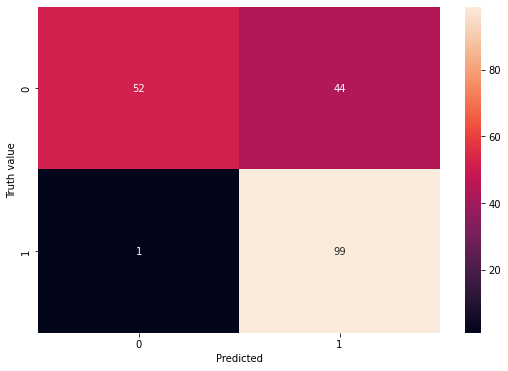

In [47]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [48]:

acc=(52+99)/(52+99+44+1)

print(" Accuracy : {0:.2f}".format(acc*100))


 Accuracy : 77.04


**SVM WITH RBF KERNEL**

In [49]:
from pyAudioAnalysis import audioTrainTest as aT
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "svm_rbf", "svm_rbf_model", False)

Analyzing file 1 of 788: train/COVID/01424527-9c3b-4b6e-96f1-9eea3150819b.wav
Analyzing file 2 of 788: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 3 of 788: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 4 of 788: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 5 of 788: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 6 of 788: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 7 of 788: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 8 of 788: train/COVID/082991fb-ee66-4970-91dd-50890f4cc9b1.wav
Analyzing file 9 of 788: train/COVID/08d5d346-6219-4e6d-ac06-ef489f2d186c.wav
Analyzing file 10 of 788: train/COVID/09115490-33a9-461c-9437-d7f71be057b0.wav
Analyzing file 11 of 788: train/COVID/0aa64689-c48a-421d-b353-c3496bad51ed.wav
Analyzing file 12 of 788: train/COVID/0b03673a-28db-4e1c-aeb0-4fec88d977a1.wav
Analyzing file 13 of 788: train/COVID/0b0d7e10-8353-4124-a16b

In [50]:
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "svm_rbf_model", "svm","COVID")

[[51 45]
 [ 5 95]]
[0.53125, 0.95] [0.9107142857142857, 0.6785714285714286] [0.6710526315789475, 0.7916666666666667] 0.7313596491228072 0.7448979591836735


Text(60.0, 0.5, 'Truth value')

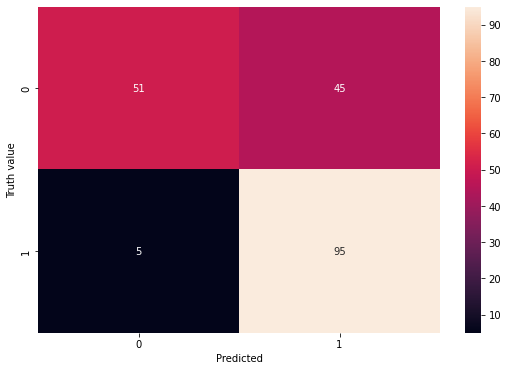

In [51]:
plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [52]:

acc=(51+95)/(51+95+45+5)

print(" Accuracy : {0:.2f}".format(acc*100))


 Accuracy : 74.49


**GEADIENT BOOSTING MODEL**

In [53]:
from pyAudioAnalysis import audioTrainTest as aT
aT.extract_features_and_train(['train/COVID','train/HEALTHY'], 1.0, 1.0, aT.shortTermWindow, aT.shortTermStep, "gradientboosting", "gb_model", False)

Analyzing file 1 of 788: train/COVID/01424527-9c3b-4b6e-96f1-9eea3150819b.wav
Analyzing file 2 of 788: train/COVID/015576c8-2b03-4dcb-b251-78a984fe86fe.wav
Analyzing file 3 of 788: train/COVID/0379c586-c500-483c-83a6-95b63afe6931.wav
Analyzing file 4 of 788: train/COVID/03d30b8b-03f8-4089-bda8-0e14deec7d82.wav
Analyzing file 5 of 788: train/COVID/0640716b-e287-4181-a653-5b798e8308c8.wav
Analyzing file 6 of 788: train/COVID/06b568b5-b9f8-4334-816c-c16009bb5de7.wav
Analyzing file 7 of 788: train/COVID/080b6119-f1ab-4337-93dd-aaccf73b4ee1.wav
Analyzing file 8 of 788: train/COVID/082991fb-ee66-4970-91dd-50890f4cc9b1.wav
Analyzing file 9 of 788: train/COVID/08d5d346-6219-4e6d-ac06-ef489f2d186c.wav
Analyzing file 10 of 788: train/COVID/09115490-33a9-461c-9437-d7f71be057b0.wav
Analyzing file 11 of 788: train/COVID/0aa64689-c48a-421d-b353-c3496bad51ed.wav
Analyzing file 12 of 788: train/COVID/0b03673a-28db-4e1c-aeb0-4fec88d977a1.wav
Analyzing file 13 of 788: train/COVID/0b0d7e10-8353-4124-a16b

In [54]:
cm, thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders(["test/COVID","test/HEALTHY"], "gb_model", "gradientboosting","COVID")

[[59 37]
 [13 87]]
[0.6145833333333334, 0.87] [0.8194444444444444, 0.7016129032258065] [0.7023809523809524, 0.7767857142857143] 0.7395833333333334 0.7448979591836735


Text(60.0, 0.5, 'Truth value')

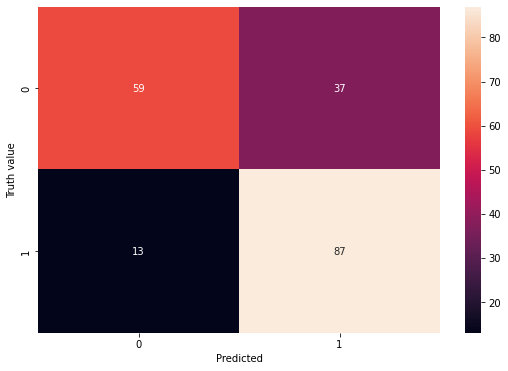

In [55]:
plt.figure(figsize=(9,6))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth value')

In [56]:
acc=(59+87)/(59+37+13+87)

print(" Accuracy : {0:.2f}".format(acc*100))

 Accuracy : 74.49
